In [1]:
import scanpy as sc
import numpy as np

import scvelo as scv

from scprotvelo._data_processing import pair_data

import warnings
warnings.filterwarnings("ignore")

# Prepare Paired Data

In [2]:
BASE_PATH = '/home/icb/sabrina.richter/git/scprotvelo/data/'

DATA_PATH = f'{BASE_PATH}data_raw/'
DATA_PATH_OUT = f'{BASE_PATH}data_paired/'

cluster_list = ['10', '8', '14', '6']

## Computationally Paired mRNA-Protein for scProtVelo

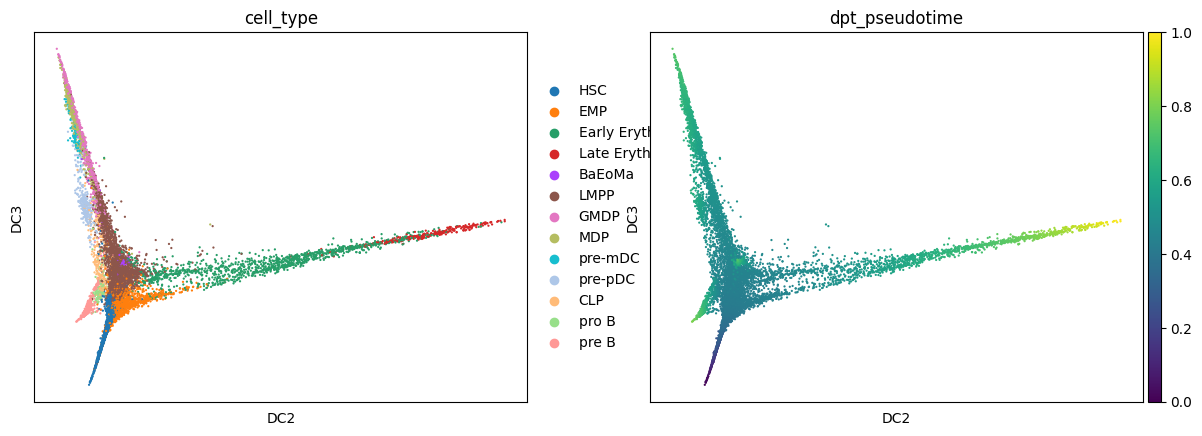

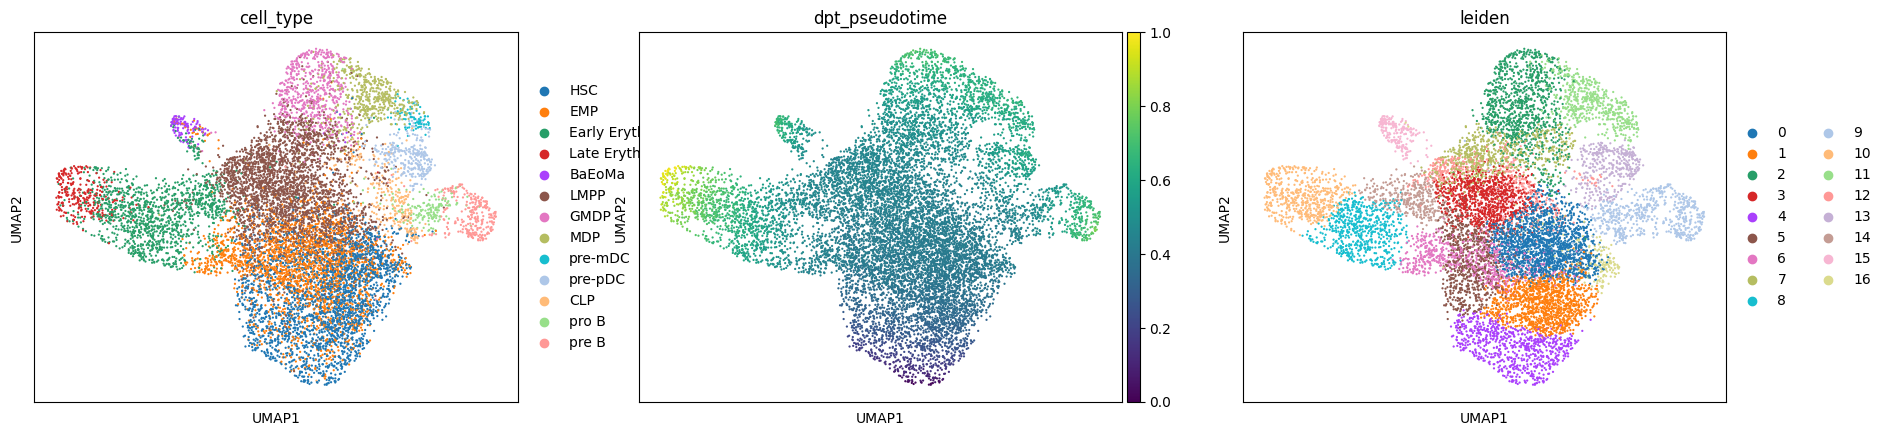

In [3]:
combined = sc.read_h5ad(f'{DATA_PATH}combined_without_layers.h5ad')

# compute diffusion pseudotime on GLUE embedding
m = np.argmin(combined.obsm['X_diffmap'][:, 2])
combined.uns['iroot'] = m
m = combined.obs.index[m]
combined.obs['xroot'] = 0
combined.obs.loc[m, 'xroot'] = 1
sc.tl.dpt(combined)
del combined.uns['iroot']
sc.pl.diffmap(combined, components=['2,3'], color=['cell_type', 'dpt_pseudotime'])

# compute leiden clustering on GLUE embedding
sc.tl.leiden(combined)
sc.pl.umap(combined, color=['cell_type', 'dpt_pseudotime', 'leiden'])

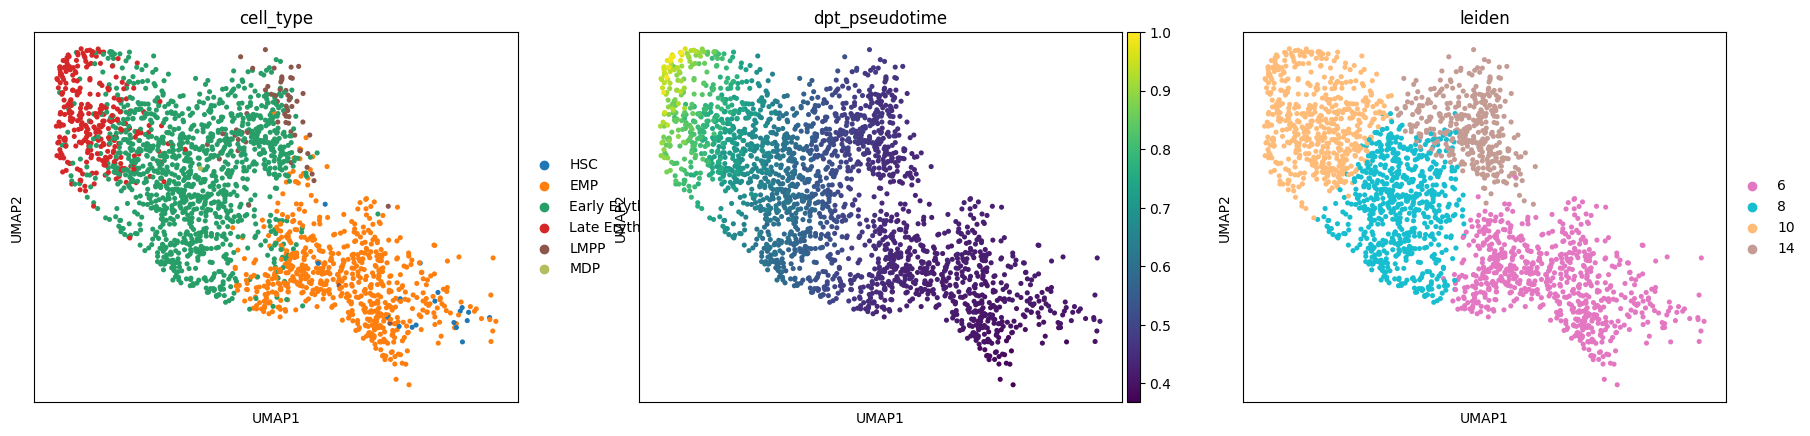

proteins after filtering for 30% completeness: 1068
mRNAs after filtering for 2% completeness: 5117
intersection: 1039

protein: 483 cells
rna: 1729 cells

147 DE genes selected:
['MYH9', 'SPTBN1', 'AHNAK', 'ANXA6', 'CLTC', 'HSPA8', 'LMNB1', 'HSP90AA1', 'VIM', 'PKM', 'NCL', 'LRPPRC', 'VCL', 'DHX9', 'HSPA9', 'PDIA3', 'MTHFD1', 'MCM7', 'HSPD1', 'TUBB', 'CCT2', 'TUFM', 'CCT7', 'ATP5F1A', 'ANXA1', 'TCP1', 'DDB1', 'DARS', 'NASP', 'SERPINB1', 'CANX', 'H2AFY', 'ATIC', 'SSB', 'RPL4', 'CORO1A', 'FKBP4', 'FSCN1', 'PPIA', 'HK1', 'HIST1H1B', 'PTPN6', 'PDCD4', 'TPM4', 'GMPS', 'GPI', 'LRRFIP1', 'CA1', 'ALDH1A1', 'HNRNPF', 'PAICS', 'TOP1', 'TUBA1C', 'EIF5A', 'PHGDH', 'PCBP1', 'GART', 'PCNA', 'SERBP1', 'LMNA', 'SERPINB6', 'FNBP1', 'ARHGDIB', 'PGD', 'OXCT1', 'HIST1H4C', 'SAE1', 'NUDC', 'H1FX', 'NOLC1', 'PTBP1', 'TAF15', 'PHB', 'LSP1', 'EIF3I', 'PSMA3', 'IPO5', 'USP7', 'HNRNPAB', 'PSMA6', 'PRDX2', 'SLC25A5', 'HMGN2', 'SSRP1', 'RPL8', 'AKR1C3', 'CACYBP', 'DDAH2', 'BLVRB', 'RAN', 'ATP5PD', 'SF3A3', 'RAC2'

In [4]:
# pair modalities by interpolating the missing modality over the GLUE embedding
adata, rna, prot = pair_data(
    data_path=DATA_PATH,
    data_path_out=DATA_PATH_OUT,
    combined=combined,
    cluster_list=cluster_list,
    file_name='paired_adata_Eryth',
    fractions=.3,
    n_cells=50,
    log_fc_prot=.1,
    log_fc_rna=.5,
)

## Paired Unspliced-Spliced for veloVI

In [5]:
# load unspliced/spliced data
bdatas = []
for p in ['old1', 'old2', 'young1', 'young2']:
    print(p)
    ldata = scv.read(f'{DATA_PATH}/cnt_{p.capitalize()}.loom')
    ldata.obs_names = [f'{o.split(":")[1][:-1]}-1-{p}' for o in ldata.obs_names]
    ldata.var_names_make_unique()
    bdatas.append(ldata)
adata_rna = sc.concat(bdatas, axis=0)
adata_rna = adata_rna[[o for o in rna.obs_names if o in adata_rna.obs_names]].copy()
adata_rna.layers['spliced'] = np.array(adata_rna.layers['spliced'].todense())
adata_rna.layers['unspliced'] = np.array(adata_rna.layers['unspliced'].todense())

# transfer metadata
adata_rna.obs = combined.obs.loc[adata_rna.obs_names, :]
adata_rna.uns = combined.uns
adata_rna.obsm['X_totalVI'] = rna[adata_rna.obs_names].obsm['X_totalVI']
adata_rna.obsm['X_umap'] = rna[adata_rna.obs_names].obsm['X_umap']
adata_rna.obs['dpt_pseudotime'] = rna[adata_rna.obs_names].obs['dpt_pseudotime']

# write
adata_rna.write(f'{DATA_PATH_OUT}paired_adata_rna.h5ad')

old1
old2
young1
young2
